In [60]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

In [61]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/home/gregory178/Desktop/NAX project/FM_Draft_15/test_data_Draft_15.csv')

# Remove rows where 'BDSPPatientID' is 122501769
df = df[df['BDSPPatientID'] != 122501769]

# Save the DataFrame back to a CSV file
df.to_csv('/home/gregory178/Desktop/NAX project/FM_Draft_15/test_data_Draft_15.csv', index=False)


In [62]:
# load testing set

#Detecting ACTIVE SDH not just sdh. Pretty great results. 

matrix = pd.read_csv('/home/gregory178/Desktop/NAX project/FM_Draft_15/test_data_Draft_15.csv')
matrix = matrix.sample(random_state = 2023, frac = 1, ignore_index=True)  # shuffle
# Drop the 'annot' column to create X_data
X_data = matrix.drop('annot', axis=1).reset_index(drop = True)

# Extract the 'BDSPPatientID' and 'annot' columns to create y_data_pre
y_data_pre = matrix[['BDSPPatientID', 'annot']].reset_index(drop = True)

assert len(X_data) == len(y_data_pre), "DataFrames must have the same length"
X_data['annot']=y_data_pre['annot']
print(X_data)

y_data = X_data[['BDSPPatientID', 'annot']]
print(y_data)
y_data_pre=y_data
print(y_data_pre)
y_holdout = y_data_pre['annot']
print(y_holdout)

X_data=X_data.drop(['annot'], axis=1)
X_holdout=X_data.drop(['BDSPPatientID', 'ContactDate', 'hospital', 'Unnamed: 0', 'NoteFileName', 'Site'], axis=1) 
print(X_holdout)
feature_names = X_holdout.columns.tolist()

      Unnamed: 0  BDSPPatientID ContactDate  \
0           1451      116551953  2017-04-12   
1           1625      150626794  2016-06-28   
2            921      111708750  2020-07-01   
3           2827      150293166  2013-11-24   
4           2675      150744963  2011-09-26   
...          ...            ...         ...   
1494        1806      150001850  2014-07-26   
1495        1048      115875112  2016-11-04   
1496        1406      115098587  2021-07-12   
1497         927      117157833  2021-03-29   
1498        1731      151195673  2015-04-27   

                                   NoteFileName   Site  CT  MRI  acut sdh_pos  \
0     Notes_13364499668_1918544682_20170412.txt    MGB   1    1             0   
1      Notes_1130485717_9766596953_20160628.txt  BIDMC   1    0             0   
2     Notes_13504793443_3523347700_20200701.txt    MGB   0    0             0   
3       Notes_1130151802_169903067_20131124.txt  BIDMC   0    0             0   
4      Notes_1130603513_143940

Accuracy: 0.9346 (95% CI: 0.9286 - 0.9520)
Precision: 0.8709 (95% CI: 0.7972 - 0.8726)
Recall (Sensitivity): 0.8406 (95% CI: 0.8994 - 0.9540)
F1 Score: 0.8555
AUC (ROC): 0.9791 (95% CI: 0.9726 - 0.9849)
AUC (PR): 0.8961 (95% CI: 0.8554 - 0.9332)
Specificity: 0.9627
False Positives: 43
False Negatives: 55


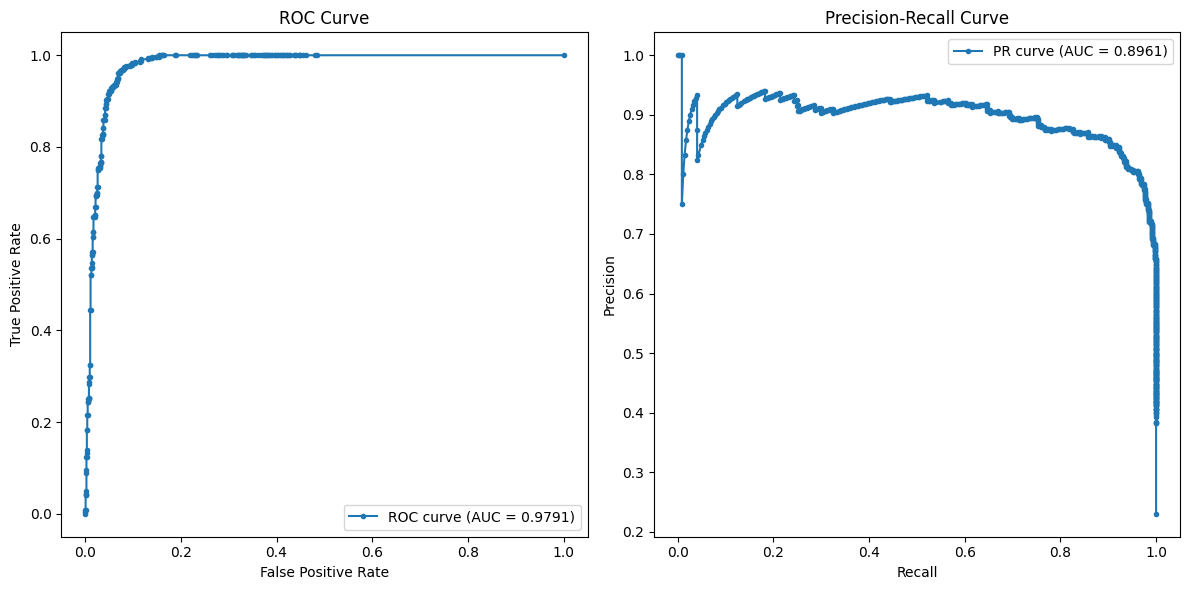

Number of False Positive Patient IDs: 43
Number of False Negative Patient IDs: 55


In [63]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, precision_score, recall_score,
    precision_recall_curve, auc, confusion_matrix, accuracy_score
)
from sklearn.utils import resample

# Function to compute confidence intervals using bootstrapping
def bootstrap_ci(y_true, y_pred_proba, metric_func, num_bootstrap=1000, alpha=0.05):
    stats = []
    for _ in range(num_bootstrap):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_bs = y_true[indices]
        y_pred_proba_bs = y_pred_proba[indices]
        stat = metric_func(y_true_bs, y_pred_proba_bs)
        stats.append(stat)
    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

# Load models and cutoffs
models = []
cutoffs = []
feature_importances_dict = {}

for fold in range(10):
    with open(f'RF_model_train_allhospitals_Notes+ICD+Med_fold{fold+1}.pickle', 'rb') as f:
        res = pickle.load(f)
    models.append(res['model'])
    cutoffs.append(res['cutoff'])
    
    # Extract feature importances
    feature_importances_dict[fold] = res['model'].feature_importances_


# Predict on holdout set
y_pred_proba = np.zeros(X_holdout.shape[0])
y_pred = np.zeros(X_holdout.shape[0])

for model, cutoff in zip(models, cutoffs):
    yp_proba = model.predict_proba(X_holdout)[:, 1]
    y_pred_proba += yp_proba
    y_pred += (yp_proba > cutoff).astype(int)

# Average probability and majority vote
y_pred_proba /= len(models)
y_pred = (y_pred > (len(models) / 2)).astype(int)



# Calculate metrics
fpr, tpr, _ = roc_curve(y_holdout, y_pred_proba)
auc_roc = roc_auc_score(y_holdout, y_pred_proba)
f1_holdout = f1_score(y_holdout, y_pred)
precision_holdout = precision_score(y_holdout, y_pred)
recall_holdout = recall_score(y_holdout, y_pred)
precision, recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)
accuracy = accuracy_score(y_holdout, y_pred)
cf_holdout = confusion_matrix(y_holdout, y_pred)

# Extract false positives, false negatives, true positives, and true negatives
tn, fp, fn, tp = cf_holdout.ravel()

# Calculate specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Compute confidence intervals
accuracy_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: accuracy_score(y, (p > 0.5).astype(int)))
precision_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: precision_score(y, (p > 0.5).astype(int)))
recall_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: recall_score(y, (p > 0.5).astype(int)))
auc_roc_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: roc_auc_score(y, p))
auc_pr_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: auc(precision_recall_curve(y, p)[1], precision_recall_curve(y, p)[0]))

# Print metrics
print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall (Sensitivity): {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f}")
print(f"AUC (ROC): {auc_roc:.4f} (95% CI: {auc_roc_ci[0]:.4f} - {auc_roc_ci[1]:.4f})")
print(f"AUC (PR): {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")
print(f"Specificity: {specificity:.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, marker='.', label=f'ROC curve (AUC = {auc_roc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='.', label=f'PR curve (AUC = {auc_pr:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Extract patient IDs for false positives and false negatives
# Ensure that the index of the DataFrame is properly aligned
# Assuming matrix.BDSPPatientID is a pandas Series with correct alignment
false_positive_ids = matrix.BDSPPatientID[(y_holdout == 0) & (y_pred == 1)]
false_negative_ids = matrix.BDSPPatientID[(y_holdout == 1) & (y_pred == 0)]

# Create DataFrames with patient IDs, annot (y_holdout), and y_pred
false_positive_df = pd.DataFrame({
    'BDSPPatientID': false_positive_ids,
    'annot': y_holdout[(y_holdout == 0) & (y_pred == 1)],
    'y_pred': y_pred[(y_holdout == 0) & (y_pred == 1)]
})

false_negative_df = pd.DataFrame({
    'BDSPPatientID': false_negative_ids,
    'annot': y_holdout[(y_holdout == 1) & (y_pred == 0)],
    'y_pred': y_pred[(y_holdout == 1) & (y_pred == 0)]
})

# Print the number of false positive and false negative patient IDs
print(f"Number of False Positive Patient IDs: {len(false_positive_df)}")
print(f"Number of False Negative Patient IDs: {len(false_negative_df)}")

# Save to CSV files
false_positive_df.to_csv("false_positive_ids.csv", index=False)
false_negative_df.to_csv("false_negative_ids.csv", index=False)


Metrics on Holdout Set:
AUC_Roc: 0.9791 (95% CI: 0.9726 - 0.9847)
F1 Score: 0.8555 (95% CI: 0.8273 - 0.8824)
Precision: 0.8709 (95% CI: 0.8328 - 0.9044)
Recall: 0.8406 (95% CI: 0.8065 - 0.8787)
Accuracy: 0.9346 (95% CI: 0.9219 - 0.9466)
AUC_PR: 0.8961 (95% CI: 0.8539 - 0.9323)


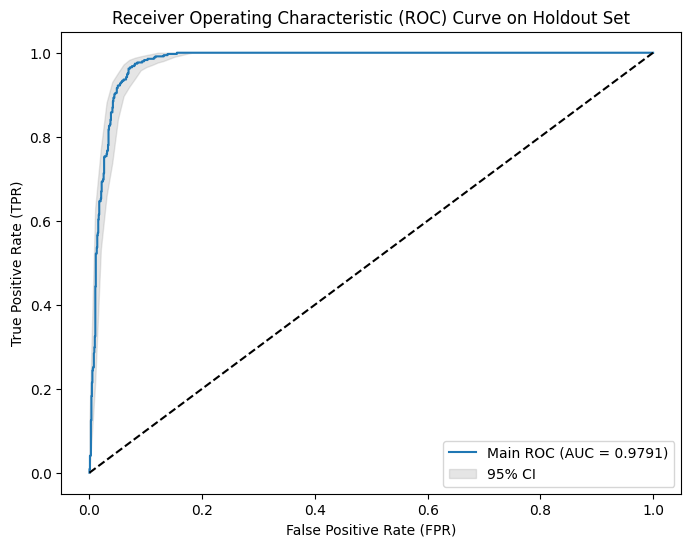

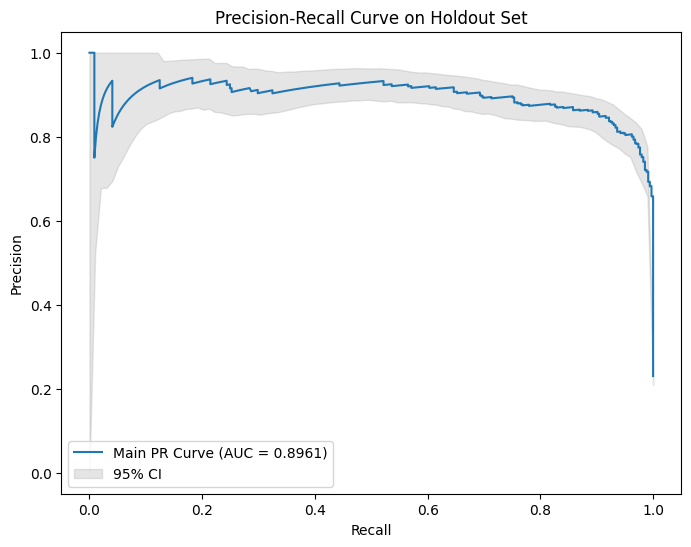

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd

def bootstrap_resample(y_true, y_pred_proba, y_pred, n_iterations=1000, alpha=0.95):
    aucs = []
    f1s = []
    precisions = []
    recalls = []
    accuracies = []
    auc_prs = []
    roc_curves = []
    pr_curves = []
    n_size = len(y_true)
    for _ in range(n_iterations):
        indices = np.random.randint(0, n_size, n_size)
        if len(np.unique(y_true[indices])) < 2:
            continue  # skip this resample if it does not have both classes
        aucs.append(roc_auc_score(y_true[indices], y_pred_proba[indices]))
        f1s.append(f1_score(y_true[indices], y_pred[indices]))
        precisions.append(precision_score(y_true[indices], y_pred[indices]))
        recalls.append(recall_score(y_true[indices], y_pred[indices]))
        accuracies.append(accuracy_score(y_true[indices], y_pred[indices]))
        precision, recall, _ = precision_recall_curve(y_true[indices], y_pred_proba[indices])
        auc_prs.append(auc(recall, precision))
        fpr, tpr, _ = roc_curve(y_true[indices], y_pred_proba[indices])
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))
    # Calculate confidence intervals
    lower_p = ((1.0 - alpha) / 2.0) * 100
    upper_p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    auc_ci = np.percentile(aucs, [lower_p, upper_p])
    f1_ci = np.percentile(f1s, [lower_p, upper_p])
    precision_ci = np.percentile(precisions, [lower_p, upper_p])
    recall_ci = np.percentile(recalls, [lower_p, upper_p])
    accuracy_ci = np.percentile(accuracies, [lower_p, upper_p])
    auc_pr_ci = np.percentile(auc_prs, [lower_p, upper_p])
    return auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, auc_pr_ci, roc_curves, pr_curves

# Perform bootstrap resampling to get confidence intervals
auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, auc_pr_ci, roc_curves_bootstrap, pr_curves_bootstrap = bootstrap_resample(y_holdout, y_pred_proba, y_pred)

# Print metrics and confidence intervals
print("Metrics on Holdout Set:")
print(f"AUC_Roc: {auc_roc:.4f} (95% CI: {auc_ci[0]:.4f} - {auc_ci[1]:.4f})")
print(f"F1 Score: {f1_holdout:.4f} (95% CI: {f1_ci[0]:.4f} - {f1_ci[1]:.4f})")
print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
print(f"Recall: {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
print(f"AUC_PR: {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")

# Calculate confidence intervals for ROC
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

# Calculate confidence intervals for PR
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)

# Plot ROC curve with confidence intervals
plt.figure(figsize=(8, 6))
main_fpr, main_tpr, _ = roc_curve(y_holdout, y_pred_proba)
main_auc = auc(main_fpr, main_tpr)
plt.plot(main_fpr, main_tpr, label=f'Main ROC (AUC = {main_auc:.4f})')
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='grey', alpha=0.2, label='95% CI')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve on Holdout Set')
plt.legend(loc='lower right')
plt.savefig('AUC_holdout.png')
plt.show()

# Plot PR curve with confidence intervals
plt.figure(figsize=(8, 6))
main_precision, main_recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
main_auc_pr = auc(main_recall, main_precision)
plt.plot(main_recall, main_precision, label=f'Main PR Curve (AUC = {main_auc_pr:.4f})')
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='grey', alpha=0.2, label='95% CI')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Holdout Set')
plt.legend(loc='lower left')
plt.savefig('PR_holdout.png')
plt.show()

# Save all the data
df_holdout = pd.DataFrame({
    'metric': ['auc', 'f1', 'precision', 'recall', 'accuracy', 'auc_pr'],
    'value': [auc_roc, f1_holdout, precision_holdout, recall_holdout, accuracy, auc_pr],
    'ci_lower': [auc_ci[0], f1_ci[0], precision_ci[0], recall_ci[0], accuracy_ci[0], auc_pr_ci[0]],
    'ci_upper': [auc_ci[1], f1_ci[1], precision_ci[1], recall_ci[1], accuracy_ci[1], auc_pr_ci[1]]
})
df_holdout.to_csv('RC_CI_holdout_metrics.csv', index=False)


Confusion Matrix:
[[1111   43]
 [  55  290]]
True Negatives (TN): 1111
False Positives (FP): 43
False Negatives (FN): 55
True Positives (TP): 290
Specificity: 0.9627
False Positives: 43
False Negatives: 55


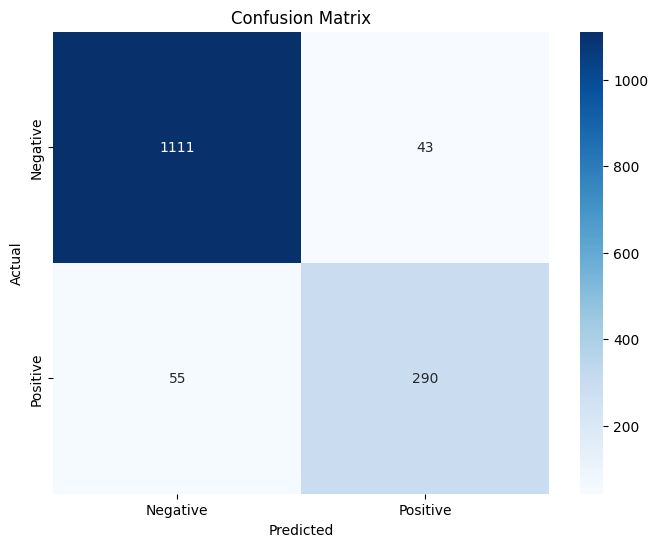

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix. #y_holdout = actual annotations. y_pred = predicted annotations. 
cf_holdout = confusion_matrix(y_holdout, y_pred)

# Extract false positives, false negatives, true positives, and true negatives
tn, fp, fn, tp = cf_holdout.ravel()

# Calculate specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(cf_holdout)
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"Specificity: {specificity:.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf_holdout, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=['Negative', 'Positive'], 
                 yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




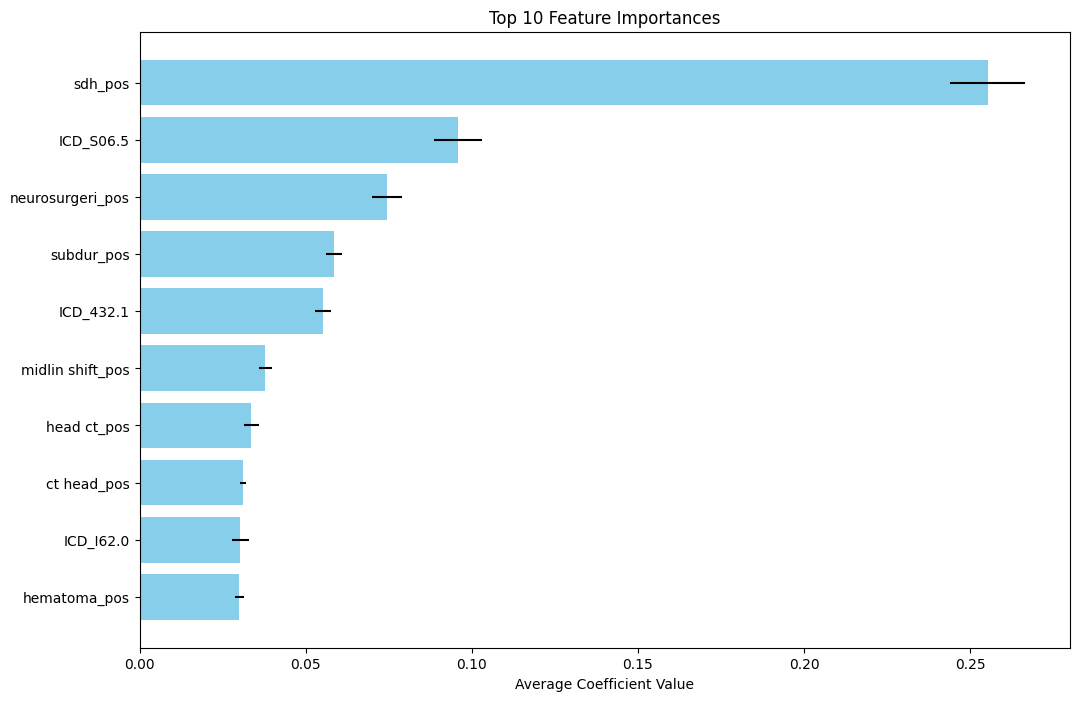

In [66]:
# Compute feature importances
all_feature_importances = np.array([importance for importance in feature_importances_dict.values()])
average_feature_importances = np.mean(all_feature_importances, axis=0)
std_feature_importances = np.std(all_feature_importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # Assuming feature_names is defined elsewhere
    'Importance': average_feature_importances,
    'Importance_se': std_feature_importances / np.sqrt(len(models))
})

# Sort and select top 10 features
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False, ignore_index=True)
top_features = feature_importance_df.head(10)
bottom_features = feature_importance_df.tail(10)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue', xerr=2*top_features['Importance_se']) 
plt.xlabel('Average Coefficient Value')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Save feature importances to CSV
feature_importance_df.to_csv('/home/gregory178/Desktop/NAX project/FM_Draft_15/feature_importances_test.csv', index=False)


In [67]:
#With Confidence intervals

# import numpy as np
# import pandas as pd
# import pickle
# from sklearn.metrics import (
#     roc_curve, roc_auc_score, f1_score, precision_score, recall_score,
#     precision_recall_curve, auc, confusion_matrix, accuracy_score
# )
# from sklearn.utils import resample

# # Function to compute confidence intervals using bootstrapping
# def bootstrap_ci(y_true, y_pred_proba, metric_func, num_bootstrap=1000, alpha=0.05):
#     stats = []
#     for _ in range(num_bootstrap):
#         indices = resample(np.arange(len(y_true)), replace=True)
#         y_true_bs = y_true[indices]
#         y_pred_proba_bs = y_pred_proba[indices]
#         stat = metric_func(y_true_bs, y_pred_proba_bs)
#         stats.append(stat)
#     lower_bound = np.percentile(stats, 100 * alpha / 2)
#     upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
#     return lower_bound, upper_bound

# # Load models and cutoffs
# models = []
# cutoffs = []
# for fold in range(10):
#     with open(f'RF_model_train_allhospitals_Notes+ICD+Med_fold{fold+1}.pickle', 'rb') as f:
#         res = pickle.load(f)
#     models.append(res['model'])
#     cutoffs.append(res['cutoff'])

# # # Load patient IDs
# # fold_patient_ids_df = pd.read_csv('RF_both_hospitals_fold_patient_ids_Draft_15.csv')

# # # Filter to include only 'test' entries and reset index for proper alignment
# # test_patient_ids = fold_patient_ids_df[fold_patient_ids_df['type'] == 'test'].reset_index(drop=True)

# # Predict on holdout set
# y_pred_proba = np.zeros(X_holdout.shape[0])
# y_pred = np.zeros(X_holdout.shape[0])

# for model, cutoff in zip(models, cutoffs):
#     yp_proba = model.predict_proba(X_holdout)[:, 1]
#     y_pred_proba += yp_proba
#     y_pred += (yp_proba > cutoff).astype(int)

# # Average probability and majority vote
# y_pred_proba /= len(models)
# y_pred = (y_pred > (len(models) / 2)).astype(int)

# # Calculate metrics
# fpr, tpr, _ = roc_curve(y_holdout, y_pred_proba)
# auc_roc = roc_auc_score(y_holdout, y_pred_proba)
# f1_holdout = f1_score(y_holdout, y_pred)
# precision_holdout = precision_score(y_holdout, y_pred)
# recall_holdout = recall_score(y_holdout, y_pred)
# precision, recall, _ = precision_recall_curve(y_holdout, y_pred_proba)
# auc_pr = auc(recall, precision)
# accuracy = accuracy_score(y_holdout, y_pred)
# cf_holdout = confusion_matrix(y_holdout, y_pred)

# # Extract false positives, false negatives, true positives, and true negatives
# tn, fp, fn, tp = cf_holdout.ravel()

# # Calculate specificity
# specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# # Compute confidence intervals
# accuracy_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: accuracy_score(y, (p > 0.5).astype(int)))
# precision_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: precision_score(y, (p > 0.5).astype(int)))
# recall_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: recall_score(y, (p > 0.5).astype(int)))
# auc_roc_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: roc_auc_score(y, p))
# auc_pr_ci = bootstrap_ci(y_holdout, y_pred_proba, lambda y, p: auc(precision_recall_curve(y, p)[1], precision_recall_curve(y, p)[0]))

# # Print metrics
# print(f"Accuracy: {accuracy:.4f} (95% CI: {accuracy_ci[0]:.4f} - {accuracy_ci[1]:.4f})")
# print(f"Precision: {precision_holdout:.4f} (95% CI: {precision_ci[0]:.4f} - {precision_ci[1]:.4f})")
# print(f"Recall (Sensitivity): {recall_holdout:.4f} (95% CI: {recall_ci[0]:.4f} - {recall_ci[1]:.4f})")
# print(f"F1 Score: {f1_holdout:.4f}")
# print(f"AUC (ROC): {auc_roc:.4f} (95% CI: {auc_roc_ci[0]:.4f} - {auc_roc_ci[1]:.4f})")
# print(f"AUC (PR): {auc_pr:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")
# print(f"Specificity: {specificity:.4f}")
# print(f"False Positives: {fp}")
# print(f"False Negatives: {fn}")

# # Plot ROC Curve
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))

# # ROC Curve
# plt.subplot(1, 2, 1)
# plt.plot(fpr, tpr, marker='.', label=f'ROC curve (AUC = {auc_roc:.4f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()

# # Precision-Recall Curve
# plt.subplot(1, 2, 2)
# plt.plot(recall, precision, marker='.', label=f'PR curve (AUC = {auc_pr:.4f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Match patient IDs to predictions
# # Ensure that the index of the DataFrame is properly aligned
# # test_patient_ids = test_patient_ids.loc[test_patient_ids.index.isin(np.arange(len(y_holdout)))]
# # false_positive_ids = test_patient_ids[(y_holdout == 0) & (y_pred == 1)]['patient_id']
# # false_negative_ids = test_patient_ids[(y_holdout == 1) & (y_pred == 0)]['patient_id']
# false_positive_ids = matrix.BDSPPatientID[(y_holdout == 0) & (y_pred == 1)]
# false_negative_ids = matrix.BDSPPatientID[(y_holdout == 1) & (y_pred == 0)]

# # Print the number of false positive and false negative patient IDs
# print(f"Number of False Positive Patient IDs: {len(false_positive_ids)}")
# print(f"Number of False Negative Patient IDs: {len(false_negative_ids)}")
# print(false_positive_ids)
# print(false_negative_ids)


# # false_positive_ids.to_csv("false_postives.csv")
# # false_negative_ids.to_csv("false_negatives.csv")

